# Bean Leaf Classification

This project aims to build a model capable of classifying diseased (Angular Leaf Spot and Bean Rust) and healthy bean leaves.

This project is from [Abubakar Abid's](https://www.linkedin.com/in/abid15/) course: <i>Building Computer Vision Applications on CoRise</i>. Learn more about the course [here](https://corise.com/course/computer-vision).


## Project Setup

Import libraries

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import evaluate
import torch
import datasets
import transformers

from datasets import load_dataset
from transformers import Trainer, TrainingArguments, ViTFeatureExtractor, ViTForImageClassification

## Data Preparation

Load the dataset

In [2]:
datasets.utils.logging.set_verbosity(datasets.logging.ERROR)
dataset = load_dataset("beans")

  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})


It can be seen that the structure of the dataset used is divided into three sets, namely train, validation, and test sets with a total of 1034, 133, and 128 rows, respectively.

Show the class distribution

In [4]:
labels = dataset['train'].features['labels'].names
values, counts = np.unique(dataset["train"]["labels"], return_counts=True)

for count, item in enumerate(counts):
    percentage = (item / sum(counts) * 100)
    print(f"{labels[count]}: {item} samples ({percentage:.2f}%)")

angular_leaf_spot: 345 samples (33.37%)
bean_rust: 348 samples (33.66%)
healthy: 341 samples (32.98%)


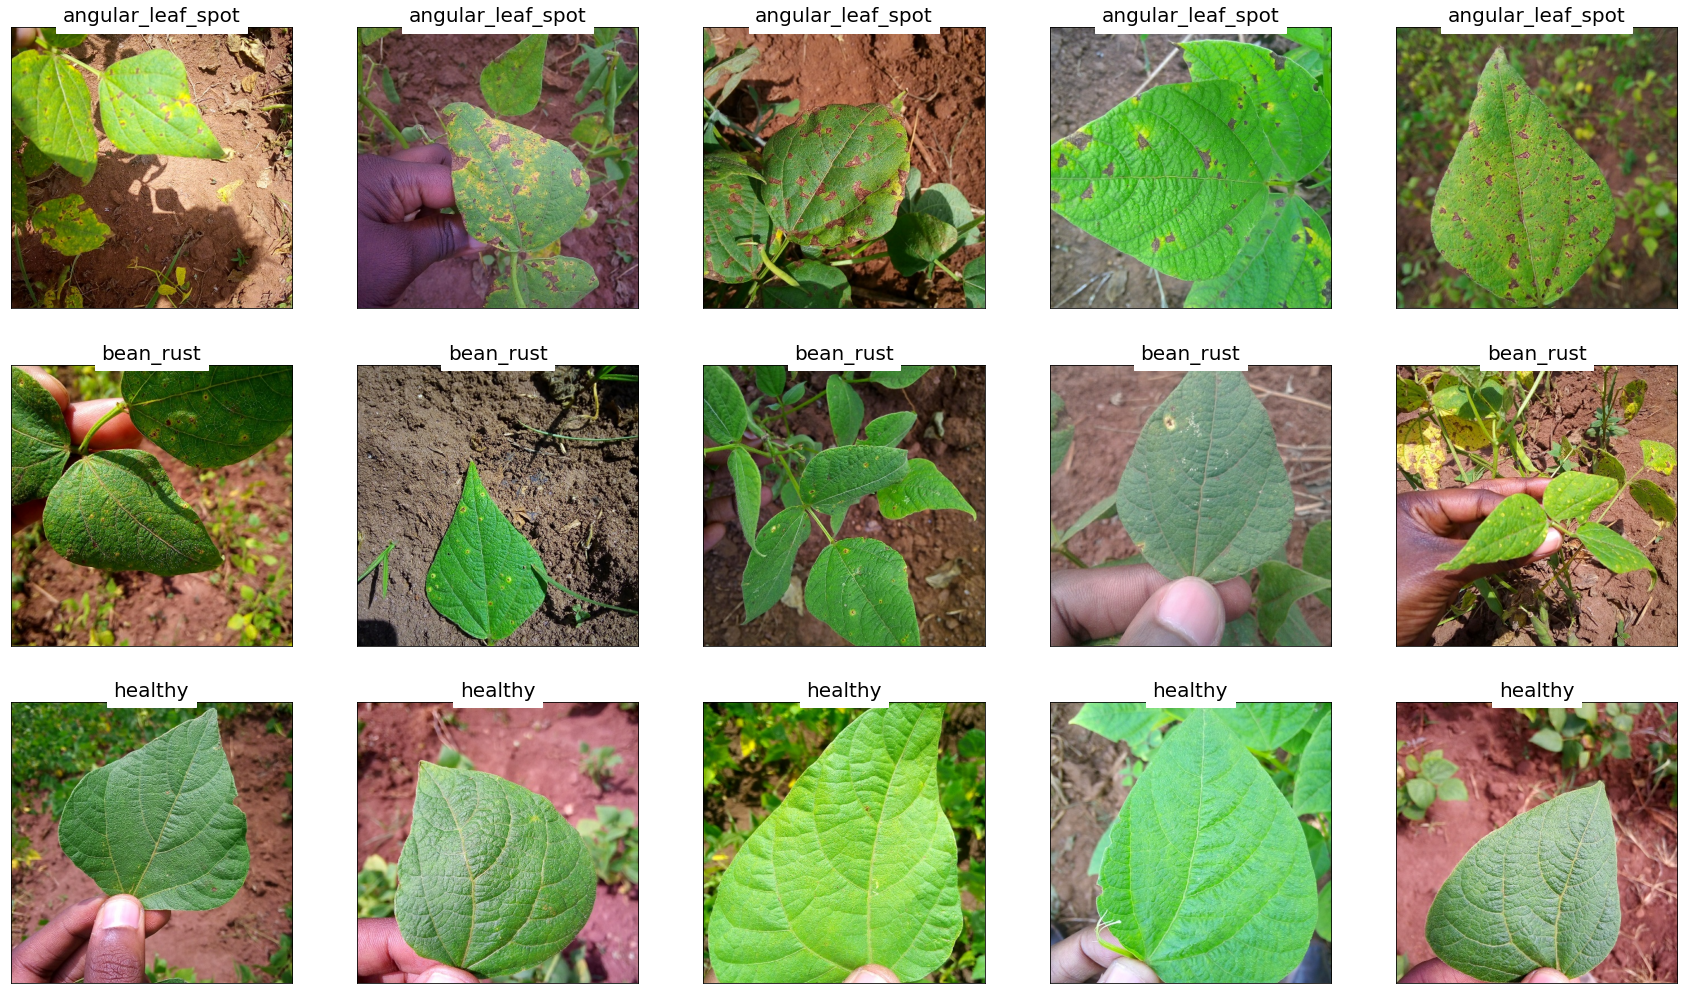

In [32]:
fig = plt.figure(figsize=(30, 30))

for i in range(15):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    if i <=4:
        index = 0
    elif i >4 and i<=9:
        index = 500
    else:
        index = 1000
    ax.imshow(dataset["train"][i+index]["image"])   
    label_name = dataset["train"][i+index]["labels"]
    ax.set_title(str(labels[label_name]), backgroundcolor='white', fontsize=20)
    

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
#model.eval()
#model.to(device);

## Loading the Pretrained Model

Load the Vision Image Transformer model

In [7]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

Load the Feature Extractor

In [8]:
encoding = feature_extractor(images=dataset['train'][1]['image'], return_tensors="pt")

In [9]:
with torch.no_grad():
    logits = model(**encoding).logits

In [10]:
prediction = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[prediction])

Predicted class: ear, spike, capitulum


Preprocess the dataset

In [11]:
def transform(example_batch):
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = dataset.with_transform(transform)

In [12]:
metric = evaluate.load("accuracy")

def compute_metrics(sample):
    return metric.compute(
        predictions=np.argmax(sample.predictions, axis=1), 
        references=sample.label_ids)

Fine-tune the VIT model

In [13]:
training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

Using amp half precision backend


In [14]:
# train_results = trainer.train()
# trainer.save_model("my_model")
# trainer.log_metrics("train", train_results.metrics)
# trainer.save_metrics("train", train_results.metrics)
# trainer.save_state()

In [15]:
# eval_accuracy = trainer.evaluate()

In [16]:
# eval_accuracy

In [17]:
# test_accuracy = trainer.predict(prepared_ds["test"])

In [18]:
# test_accuracy.metrics

In [29]:
transformers.utils.logging.set_verbosity(transformers.logging.ERROR)
fine_tuned = ViTForImageClassification.from_pretrained("vit-base-beans/checkpoint-200").to(device)

In [20]:
labels = dataset['train'].features['labels'].names

def classify(im):
  features = feature_extractor(im, return_tensors='pt').to(device)
  logits = fine_tuned(features["pixel_values"])[-1]
  probability = torch.nn.functional.softmax(logits, dim=-1)
  probs = probability[0].detach().cpu().numpy()
  confidences = {label: float(probs[i]) for i, label in enumerate(labels)} 
  return confidences

Build a demo app using Gradio

In [23]:
import gradio as gr

interface = gr.Interface(
    fn=classify, 
    inputs="image", 
    outputs=gr.Label(num_top_classes=3),
    examples=["ex1.png", "ex2.png"])

interface.launch()

Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x252f447aca0>, 'http://127.0.0.1:7860/', None)